In [1]:
# !pip install --upgrade pip
# !pip install xgboost 

In [7]:
import os 
import random
import pandas as pd
import numpy as np
from copy import deepcopy
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [8]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

In [21]:
seed = 1
set_random_seed(seed)

base_dir = './dataset/'

# load the positive and negative QA pairs
all_pos_df = pd.read_csv(os.path.join(base_dir, 'positive_general_labels.csv'))
all_neg_df = pd.read_csv(os.path.join(base_dir, 'negative_labels.csv'))

# shuffle each set individually
# p = np.random.permutation(all_pos_df.index)
# all_pos_df = all_pos_df.reindex(p)
# all_neg_df = all_neg_df.reindex(p)

print('All positive samples:', all_pos_df.shape)
print('All negative samples:', all_neg_df.shape)

# check a sample data point for positive and negative labels
print(all_pos_df.iloc[10])
print(all_neg_df.iloc[10])


# put the first "test_size" QA pos and neg labels in the test dataset
test_size = 500
test_df = all_pos_df[:test_size]
test_df = test_df.append(all_neg_df[:test_size])

# put the second "test_size" QA pos and neg labels in the validation dataset
valid_df = all_pos_df[test_size:2*test_size]
valid_df = valid_df.append(all_neg_df[test_size:2*test_size])

# put all the other pairs in the training dataset
train_df = all_pos_df[2*test_size:]
train_df = train_df.append(all_neg_df[2*test_size:])

print('Training dataset:', train_df.shape)
print('Validation dataset:', valid_df.shape)
print('Test dataset:', test_df.shape)

All positive samples: (4410, 5)
All negative samples: (4137, 5)
question_id                             56bc751eac7ad10019000013
question          Name synonym of Acrokeratosis paraneoplastica.
answer         Acrokeratosis paraneoplastic (Bazex syndrome) ...
label                                                       True
source                                     BioASQ_TR_IdealAnswer
Name: 10, dtype: object
question_id                             56bc751eac7ad10019000013
question          Name synonym of Acrokeratosis paraneoplastica.
answer         he conditioned infections due to opportunistic...
label                                                      False
source                                                   CORD-19
Name: 10, dtype: object
Training dataset: (6547, 5)
Validation dataset: (1000, 5)
Test dataset: (1000, 5)


In [22]:
def clustering_active_learner(data, b_size, probs):
        
    X = np.zeros((data.shape[0], len(sentences_embeds[0])))
    for i in range(data.shape[0]):
        s_id = sentence_ids[data.iloc[i]['question'] + ' ' + data.iloc[i]['answer']]
        X[i, :] = sentences_embeds[s_id]
        
    kernel = KMeans(n_clusters=b_size, verbose=0, n_jobs=-1, random_state=1) 
    kernel = kernel.fit(X)     
    labels = kernel.predict(X)

    cluster_min = np.ones((b_size, 2))
    sampled = pd.DataFrame(columns=data.columns)
    for i in range(data.shape[0]):
        if np.max(probs[i, :]) < cluster_min[labels[i], 0]:
            cluster_min[labels[i], 0] = np.max(probs[i, :])
            cluster_min[labels[i], 1] = i

    for i in cluster_min[:, 1]:
        sampled = sampled.append(data.iloc[int(i)])

    remaining = data.drop(sampled.index, axis=0)

    return sampled, remaining
    

In [23]:
def uncertainty_active_learner(data, b_size, probs):
    
    # step 1: find the higher probability
    # step 2: sort these probabilities
    # step 3: choose the ones that have the lowest probability
    sorted_arg = np.argsort(np.amax(probs, axis=1))
    
    sampled = data.drop(list(sorted_arg[b_size:]))
    remaining = data.drop(list(sorted_arg[:b_size]))

    return sampled, remaining

In [24]:
def random_active_learner(data, b_size=10, seed=0):
    sampled = data.sample(n=b_size, random_state=seed)
    remaining = data.drop(sampled.index)

    return sampled, remaining
    

In [25]:
sentence_ids = pickle.load(open('pos_general_neg_bert_sbert_sentence_ids.pkl', 'rb'))
sentences_embeds = pickle.load(open('pos_general_neg_bert_sbert_sentence_embeddings.pkl', 'rb'))

def to_features(data):
    X = np.zeros((data.shape[0], 768))
    Y = np.zeros((data.shape[0], 1), dtype=bool)
    
    for i in range(data.shape[0]):
        s_id = sentence_ids[data.iloc[i]['question'] + ' ' + data.iloc[i]['answer']]
        X[i, :] = sentences_embeds[s_id]
        Y[i, :] = data.iloc[i]['label']
        
    return X, Y

In [26]:
def eval_results(model, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, eval_metrics):
    Y_train_pred = model.predict(X_train)
    train_predictions = [round(value) for value in Y_train_pred]
    train_accuracy = accuracy_score(Y_train, train_predictions)
    train_f1 = f1_score(Y_train, train_predictions)
    print('Train accuracy:', train_accuracy, ' - Train f1:', train_f1)

    Y_valid_pred = model.predict(X_valid)
    valid_predictions = [round(value) for value in Y_valid_pred]
    valid_accuracy = accuracy_score(Y_valid, valid_predictions)
    valid_f1 = f1_score(Y_valid, valid_predictions)
    print('Valid accuracy:', valid_accuracy, ' - Valid f1:', valid_f1)

    Y_test_pred = model.predict(X_test)
    test_predictions = [round(value) for value in Y_test_pred]
    test_accuracy = accuracy_score(Y_test, test_predictions)
    test_f1 = f1_score(Y_test, test_predictions)
    print('Test accuracy:', test_accuracy, ' - Test f1:', test_f1)

    eval_metrics.append([train_accuracy, train_f1, valid_accuracy, valid_f1, test_accuracy, test_f1])
    return test_accuracy, test_f1

In [15]:
xgb_params = {
    "n_jobs": -1, 
    "max_depth": 25, 
    "min_child_weight": 0.1,
    "gamma": 1,
    "eta": 0.001,
    "num_round": 10000,
    "subsample": 0.5,
    "colsample_bytree": 0.5,
    "verbosity": 0, 
    "tree_method": 'hist', 
    "objective": 'binary:logistic'    
}

xgb_model = XGBClassifier()
xgb_model.set_params(**xgb_params)
X_train, Y_train = to_features(train_df)
X_valid, Y_valid = to_features(valid_df)
X_test, Y_test = to_features(test_df)

print('Started fitting...')
xgb_model.fit(X_train, Y_train,
              eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
              eval_metric='error',
              verbose=False)
print('Finished fitting.')
eval_metrics = []
print('Started predicting...')
acc, f1 = eval_results(xgb_model, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, eval_metrics)
print('Finished predicting.')
print(acc, f1)

Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9791201785145043  - Train f1: 0.9792885375494071
Valid accuracy: 0.899  - Valid f1: 0.9020368574199806
Test accuracy: 0.893  - Test f1: 0.8970163618864292
Finished predicting.
0.893 0.8970163618864292


In [27]:
pickle.dump(eval_metrics, open('pos_general_neg_bert_sbert_eval_metrics-AllTraining.pkl', 'wb'))

In [28]:
seed = 0
set_random_seed(seed)

batch_size = 20

pool_df = deepcopy(train_df)
pool_df.reset_index(drop=True, inplace=True)
annotated_df = pd.DataFrame(columns=pool_df.columns)

seed_df, pool_no_seed_df = random_active_learner(data=pool_df, 
                                               b_size=batch_size, 
                                               seed=seed)

pool_no_seed_df.reset_index(drop=True, inplace=True)
seed_df.reset_index(drop=True, inplace=True)    

#X_train, Y_train = to_features(pool_df)
X_train, Y_train = to_features(seed_df)
X_valid, Y_valid = to_features(valid_df)
X_test, Y_test = to_features(test_df)
    
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

print(np.unique(Y_train))
print(np.unique(Y_valid))
print(np.unique(Y_test))

(20, 768)
(1000, 768)
(1000, 768)
[False  True]
[False  True]
[False  True]


In [29]:
xgb_params = {
    "n_jobs": -1, 
    "max_depth": 25, 
    "min_child_weight": 0.1,
    "gamma": 1,
    "eta": 0.001,
    "num_round": 10000,
    "subsample": 0.5,
    "colsample_bytree": 0.5,
    "verbosity": 0, 
    "tree_method": 'hist', 
    "objective": 'binary:logistic'    
}

xgb_model = XGBClassifier()
xgb_model.set_params(**xgb_params)

print('Started fitting...')
xgb_model.fit(X_train, Y_train,
              eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
              eval_metric='error',
              verbose=False)
print('Finished fitting.')
eval_metrics = []
pickle.dump(xgb_model, open('sbert_xgboost_start_model.pkl', "wb"))
print('Started predicting...')
acc, f1 = eval_results(xgb_model, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, eval_metrics)
print('Finished predicting.')
print(acc, f1)

Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.651  - Valid f1: 0.48449039881831607
Test accuracy: 0.616  - Test f1: 0.4055727554179567
Finished predicting.
0.616 0.4055727554179567


In [30]:
batch_size = 5

strategy_results = {}
for al_strategy in ['uncertainty', 'random', 'clustering']:
    print("Using {} Strategy ====>".format(al_strategy))
    al_iterations = 50
    
    xgb_model = pickle.load(open('sbert_xgboost_start_model.pkl', "rb"))
    
    eval_metrics = []
    print('Started predicting...')
    acc, f1 = eval_results(xgb_model, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, eval_metrics)
    print('Finished predicting.')

    pool_df = deepcopy(pool_no_seed_df)
    pool_df.reset_index(drop=True, inplace=True)
    annotated_df = deepcopy(seed_df)
    print('Pool size:', pool_df.shape, ' - Annotated size:', annotated_df.shape)
    
    f1_list = [f1]
    acc_list = [acc]
    
    for i in range(al_iterations):
        print('********** AL Iteration', i, '**************')

        print('Evaluate pool dataset...')
        X_pool, Y_pool = to_features(pool_df)
        predicted_prob = xgb_model.predict_proba(X_pool)
        print('Evaluation Done.')

        if al_strategy == 'random':
            to_annotate_i, pool_df = random_active_learner(data=pool_df, 
                                                   b_size=batch_size, 
                                                   seed=seed)
        elif al_strategy == 'uncertainty':
            to_annotate_i, pool_df = uncertainty_active_learner(data=pool_df, 
                                                        b_size=batch_size, 
                                                        probs=predicted_prob)
        elif al_strategy == 'uncertainty_diversity':
            to_annotate_i, pool_df = uncertainty_diversity_active_learner(data=pool_df, 
                                                                          b_size=batch_size, 
                                                                          probs=predicted_prob)
        elif al_strategy == 'clustering':
            to_annotate_i, pool_df = clustering_active_learner(data=pool_df, 
                                                              b_size=batch_size, 
                                                              probs=predicted_prob)
        else:
            print('ERROR: Wrong AL Option.')
            break

        pool_df.reset_index(drop=True, inplace=True)
        to_annotate_i.reset_index(drop=True, inplace=True)

        annotated_df = pd.concat([annotated_df, to_annotate_i], axis=0, join='outer')
        annotated_df.reset_index(drop=True, inplace=True)

        print('Pool:', pool_df.shape, ' - to_annotate_i:', to_annotate_i.shape, ' - annotated:', annotated_df.shape)

        print('Creating features...')
        X_train, Y_train = to_features(annotated_df)
        print('Features created.')

        print('Started fitting...')
        xgb_model = XGBClassifier()
        xgb_model.set_params(**xgb_params)

        xgb_model.fit(X_train, Y_train,
                      eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
                      eval_metric='logloss',
                      verbose=False)
        print('Finished fitting.')

        print('Started predicting...')
        acc, f1 = eval_results(xgb_model, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, eval_metrics)
        acc_list.append(acc)
        f1_list.append(f1)
        print('Finished predicting.')
        
    strategy_results[al_strategy] = [acc_list, f1_list]
    if al_strategy == 'clustering':
        pickle.dump(eval_metrics, open('pos_general_neg_bert_sbert_eval_metrics-ALC1-bs5.pkl', 'wb'))
    elif al_strategy == 'uncertainty':
        pickle.dump(eval_metrics, open('pos_general_neg_bert_sbert_eval_metrics-ALU1-bs5.pkl', 'wb'))
    else:
        pickle.dump(eval_metrics, open('pos_general_neg_bert_sbert_eval_metrics-RND1-bs5.pkl', 'wb'))

Using uncertainty Strategy ====>
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.651  - Valid f1: 0.48449039881831607
Test accuracy: 0.616  - Test f1: 0.4055727554179567
Finished predicting.
Pool size: (6527, 5)  - Annotated size: (20, 5)
********** AL Iteration 0 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6522, 5)  - to_annotate_i: (5, 5)  - annotated: (25, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.761  - Valid f1: 0.71849234393404
Test accuracy: 0.738  - Test f1: 0.6797066014669927
Finished predicting.
********** AL Iteration 1 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6517, 5)  - to_annotate_i: (5, 5)  - annotated: (30, 5)
Creating features...
Features created.
Started fitting...
Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.697  - Valid f1: 0.5932885906040268
Test accuracy: 0.648  - Test f1: 0.5
Finished predicting.
********** AL Iteration 2 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6512, 5)  - to_annotate_i: (5, 5)  - annotated: (35, 5)
Creating features...
Features created.
Started fitting...
Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.811  - Valid f1: 0.8020942408376963
Test accuracy: 0.792  - Test f1: 0.7777777777777778
Finished predictin

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.776  - Valid f1: 0.7383177570093459
Test accuracy: 0.769  - Test f1: 0.7226890756302521
Finished predicting.
********** AL Iteration 1 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6517, 5)  - to_annotate_i: (5, 5)  - annotated: (30, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.828  - Valid f1: 0.8244897959183675
Test accuracy: 0.822  - Test f1: 0.8157349896480331
Finished predicting.
********** AL Iteration 2 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6512, 5)  - to_annotate_i: (5, 5)  - annotated: (35, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.847  - Valid f1: 0.8498527968596663
Test accuracy: 0.851  - Test f1: 0.8560386473429952
Finished predicting.
********** AL Iteration 3 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6507, 5)  - to_annotate_i: (5, 5)  - annotated: (40, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.838  - Valid f1: 0.8360323886639677
Test accuracy: 0.822  - Test f1: 0.8161157024793388
Finished predicting.
********** AL Iteration 4 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6502, 5)  - to_annotate_i: (5, 5)  - annotated: (45, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.828  - Valid f1: 0.8150537634408602
Test accuracy: 0.805  - Test f1: 0.7868852459016394
Finished predicting.
********** AL Iteration 5 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6497, 5)  - to_annotate_i: (5, 5)  - annotated: (50, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.849  - Valid f1: 0.8494516450648055
Test accuracy: 0.863  - Test f1: 0.863681592039801
Finished predicting.
********** AL Iteration 6 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6492, 5)  - to_annotate_i: (5, 5)  - annotated: (55, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.814  - Valid f1: 0.8238636363636365
Test accuracy: 0.829  - Test f1: 0.835734870317003
Finished predicting.
********** AL Iteration 7 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6487, 5)  - to_annotate_i: (5, 5)  - annotated: (60, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.83  - Valid f1: 0.836852207293666
Test accuracy: 0.848  - Test f1: 0.8535645472061658
Finished predicting.
********** AL Iteration 8 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6482, 5)  - to_annotate_i: (5, 5)  - annotated: (65, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.838  - Valid f1: 0.8389662027833001
Test accuracy: 0.844  - Test f1: 0.8464566929133859
Finished predicting.
********** AL Iteration 9 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6477, 5)  - to_annotate_i: (5, 5)  - annotated: (70, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.819  - Valid f1: 0.8223748773307163
Test accuracy: 0.85  - Test f1: 0.8543689320388349
Finished predicting.
********** AL Iteration 10 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6472, 5)  - to_annotate_i: (5, 5)  - annotated: (75, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.839  - Valid f1: 0.8388388388388388
Test accuracy: 0.852  - Test f1: 0.8525896414342629
Finished predicting.
********** AL Iteration 11 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6467, 5)  - to_annotate_i: (5, 5)  - annotated: (80, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.845  - Valid f1: 0.8466864490603362
Test accuracy: 0.862  - Test f1: 0.8641732283464567
Finished predicting.
********** AL Iteration 12 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6462, 5)  - to_annotate_i: (5, 5)  - annotated: (85, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.853  - Valid f1: 0.8504577822990844
Test accuracy: 0.854  - Test f1: 0.8528225806451613
Finished predicting.
********** AL Iteration 13 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6457, 5)  - to_annotate_i: (5, 5)  - annotated: (90, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.821  - Valid f1: 0.8097768331562168
Test accuracy: 0.822  - Test f1: 0.8118393234672305
Finished predicting.
********** AL Iteration 14 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6452, 5)  - to_annotate_i: (5, 5)  - annotated: (95, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.852  - Valid f1: 0.8489795918367347
Test accuracy: 0.87  - Test f1: 0.8689516129032256
Finished predicting.
********** AL Iteration 15 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6447, 5)  - to_annotate_i: (5, 5)  - annotated: (100, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.845  - Valid f1: 0.8432760364004043
Test accuracy: 0.863  - Test f1: 0.8623115577889447
Finished predicting.
********** AL Iteration 16 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6442, 5)  - to_annotate_i: (5, 5)  - annotated: (105, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.836  - Valid f1: 0.8333333333333331
Test accuracy: 0.844  - Test f1: 0.844311377245509
Finished predicting.
********** AL Iteration 17 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6437, 5)  - to_annotate_i: (5, 5)  - annotated: (110, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.82  - Valid f1: 0.8178137651821863
Test accuracy: 0.848  - Test f1: 0.8498023715415021
Finished predicting.
********** AL Iteration 18 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6432, 5)  - to_annotate_i: (5, 5)  - annotated: (115, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.855  - Valid f1: 0.853387259858443
Test accuracy: 0.869  - Test f1: 0.8688688688688687
Finished predicting.
********** AL Iteration 19 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6427, 5)  - to_annotate_i: (5, 5)  - annotated: (120, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.836  - Valid f1: 0.8449905482041588
Test accuracy: 0.85  - Test f1: 0.8595505617977528
Finished predicting.
********** AL Iteration 20 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6422, 5)  - to_annotate_i: (5, 5)  - annotated: (125, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.853  - Valid f1: 0.8582449373191899
Test accuracy: 0.857  - Test f1: 0.8626320845341018
Finished predicting.
********** AL Iteration 21 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6417, 5)  - to_annotate_i: (5, 5)  - annotated: (130, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.852  - Valid f1: 0.8531746031746033
Test accuracy: 0.875  - Test f1: 0.8768472906403941
Finished predicting.
********** AL Iteration 22 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6412, 5)  - to_annotate_i: (5, 5)  - annotated: (135, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.857  - Valid f1: 0.8607594936708861
Test accuracy: 0.869  - Test f1: 0.8726919339164237
Finished predicting.
********** AL Iteration 23 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6407, 5)  - to_annotate_i: (5, 5)  - annotated: (140, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.853  - Valid f1: 0.8528528528528527
Test accuracy: 0.851  - Test f1: 0.8499496475327292
Finished predicting.
********** AL Iteration 24 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6402, 5)  - to_annotate_i: (5, 5)  - annotated: (145, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.993103448275862  - Train f1: 0.9933774834437086
Valid accuracy: 0.852  - Valid f1: 0.8508064516129031
Test accuracy: 0.855  - Test f1: 0.8536831483350151
Finished predicting.
********** AL Iteration 25 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6397, 5)  - to_annotate_i: (5, 5)  - annotated: (150, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.848  - Valid f1: 0.8503937007874015
Test accuracy: 0.834  - Test f1: 0.83852140077821
Finished predicting.
********** AL Iteration 26 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6392, 5)  - to_annotate_i: (5, 5)  - annotated: (155, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.851  - Valid f1: 0.8526211671612265
Test accuracy: 0.868  - Test f1: 0.8715953307392996
Finished predicting.
********** AL Iteration 27 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6387, 5)  - to_annotate_i: (5, 5)  - annotated: (160, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.99375  - Train f1: 0.9941520467836257
Valid accuracy: 0.856  - Valid f1: 0.8574257425742574
Test accuracy: 0.841  - Test f1: 0.8442703232125367
Finished predicting.
********** AL Iteration 28 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6382, 5)  - to_annotate_i: (5, 5)  - annotated: (165, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.853  - Valid f1: 0.8614514608859567
Test accuracy: 0.849  - Test f1: 0.8574126534466477
Finished predicting.
********** AL Iteration 29 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6377, 5)  - to_annotate_i: (5, 5)  - annotated: (170, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.854  - Valid f1: 0.8614800759013282
Test accuracy: 0.846  - Test f1: 0.8558052434456929
Finished predicting.
********** AL Iteration 30 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6372, 5)  - to_annotate_i: (5, 5)  - annotated: (175, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.876  - Valid f1: 0.8803088803088803
Test accuracy: 0.879  - Test f1: 0.8830917874396135
Finished predicting.
********** AL Iteration 31 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6367, 5)  - to_annotate_i: (5, 5)  - annotated: (180, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.859  - Valid f1: 0.8629737609329446
Test accuracy: 0.863  - Test f1: 0.8693994280266921
Finished predicting.
********** AL Iteration 32 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6362, 5)  - to_annotate_i: (5, 5)  - annotated: (185, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.858  - Valid f1: 0.8677839851024208
Test accuracy: 0.859  - Test f1: 0.8707607699358387
Finished predicting.
********** AL Iteration 33 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6357, 5)  - to_annotate_i: (5, 5)  - annotated: (190, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.87  - Valid f1: 0.878048780487805
Test accuracy: 0.883  - Test f1: 0.889934148635936
Finished predicting.
********** AL Iteration 34 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6352, 5)  - to_annotate_i: (5, 5)  - annotated: (195, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.859  - Valid f1: 0.8640308582449374
Test accuracy: 0.873  - Test f1: 0.87823585810163
Finished predicting.
********** AL Iteration 35 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6347, 5)  - to_annotate_i: (5, 5)  - annotated: (200, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.851  - Valid f1: 0.8579599618684463
Test accuracy: 0.87  - Test f1: 0.8778195488721805
Finished predicting.
********** AL Iteration 36 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6342, 5)  - to_annotate_i: (5, 5)  - annotated: (205, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.862  - Valid f1: 0.8683206106870228
Test accuracy: 0.863  - Test f1: 0.8698955365622033
Finished predicting.
********** AL Iteration 37 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6337, 5)  - to_annotate_i: (5, 5)  - annotated: (210, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.858  - Valid f1: 0.8652751423149906
Test accuracy: 0.859  - Test f1: 0.8668555240793202
Finished predicting.
********** AL Iteration 38 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6332, 5)  - to_annotate_i: (5, 5)  - annotated: (215, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.872  - Valid f1: 0.8732673267326732
Test accuracy: 0.885  - Test f1: 0.8882410106899902
Finished predicting.
********** AL Iteration 39 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6327, 5)  - to_annotate_i: (5, 5)  - annotated: (220, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9954545454545455  - Train f1: 0.9956331877729258
Valid accuracy: 0.868  - Valid f1: 0.8718446601941748
Test accuracy: 0.887  - Test f1: 0.892278360343184
Finished predicting.
********** AL Iteration 40 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6322, 5)  - to_annotate_i: (5, 5)  - annotated: (225, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.879  - Valid f1: 0.8796019900497511
Test accuracy: 0.874  - Test f1: 0.8762278978388998
Finished predicting.
********** AL Iteration 41 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6317, 5)  - to_annotate_i: (5, 5)  - annotated: (230, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.865  - Valid f1: 0.8672566371681416
Test accuracy: 0.888  - Test f1: 0.8912621359223302
Finished predicting.
********** AL Iteration 42 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6312, 5)  - to_annotate_i: (5, 5)  - annotated: (235, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.865  - Valid f1: 0.8705656759348034
Test accuracy: 0.875  - Test f1: 0.8824082784571966
Finished predicting.
********** AL Iteration 43 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6307, 5)  - to_annotate_i: (5, 5)  - annotated: (240, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.883  - Valid f1: 0.8862973760932944
Test accuracy: 0.869  - Test f1: 0.8779123951537744
Finished predicting.
********** AL Iteration 44 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6302, 5)  - to_annotate_i: (5, 5)  - annotated: (245, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.868  - Valid f1: 0.8677354709418837
Test accuracy: 0.863  - Test f1: 0.8658178256611166
Finished predicting.
********** AL Iteration 45 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6297, 5)  - to_annotate_i: (5, 5)  - annotated: (250, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.873  - Valid f1: 0.8710659898477157
Test accuracy: 0.873  - Test f1: 0.8723618090452261
Finished predicting.
********** AL Iteration 46 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6292, 5)  - to_annotate_i: (5, 5)  - annotated: (255, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.879  - Valid f1: 0.882865440464666
Test accuracy: 0.87  - Test f1: 0.8737864077669903
Finished predicting.
********** AL Iteration 47 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6287, 5)  - to_annotate_i: (5, 5)  - annotated: (260, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.874  - Valid f1: 0.8745019920318725
Test accuracy: 0.863  - Test f1: 0.8663414634146341
Finished predicting.
********** AL Iteration 48 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6282, 5)  - to_annotate_i: (5, 5)  - annotated: (265, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.872  - Valid f1: 0.8714859437751004
Test accuracy: 0.876  - Test f1: 0.8764940239043826
Finished predicting.
********** AL Iteration 49 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (6277, 5)  - to_annotate_i: (5, 5)  - annotated: (270, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.868  - Valid f1: 0.8666666666666666
Test accuracy: 0.859  - Test f1: 0.859421734795613
Finished predicting.


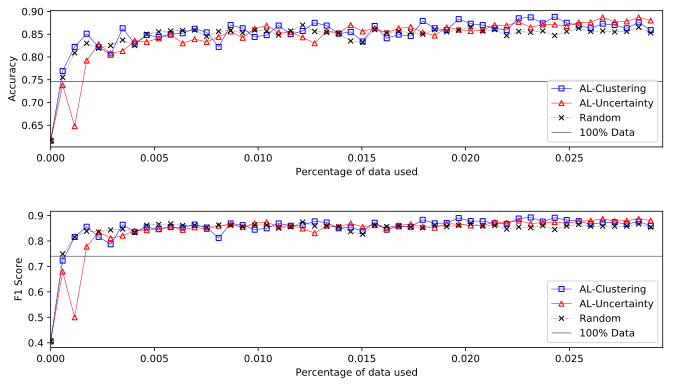

In [31]:
ACH_performance = np.asarray(pickle.load(open('pos_general_neg_bert_sbert_eval_metrics-AllTraining.pkl', 'rb')))
ALU_performance = np.asarray(pickle.load(open('pos_general_neg_bert_sbert_eval_metrics-ALU1-bs5.pkl', 'rb')))
ALC_performance = np.asarray(pickle.load(open('pos_general_neg_bert_sbert_eval_metrics-ALC1-bs5.pkl', 'rb')))
RND_performance = np.asarray(pickle.load(open('pos_general_neg_bert_sbert_eval_metrics-RND1-bs5.pkl', 'rb')))

RND_marker, ALU_marker, ALC_marker = 'x', '^', 's'
RND_color, ALU_color, ALC_color = 'black', 'red', 'blue'
RND_lstyle, ALU_lstyle, ALC_lstyle = 'dotted', 'solid', 'solid'
RND_fstyle, ALU_fstyle, ALC_fstyle = 'none', 'none', 'none'
RND_msize, ALU_msize, ALC_msize = 5, 5, 5
RND_lwidth, ALU_lwidth, ALC_lwidth = 0.5, 0.5, 0.5

ACH_color = 'black'
ACH_lwidth = 0.5

p_step = 5/8644


#### TEST
plt.figure(figsize=(10,6))
#plt.suptitle('Performance of the Test Dataset')
plt.subplot(211)
plt.hlines(y=ACH_performance[0, 4], xmin=0, xmax=len(RND_performance)*(5/6274), label='100% Data',
          color=ACH_color, linewidth=ACH_lwidth) 
plt.plot(np.arange(0, len(RND_performance)*p_step, p_step), ALC_performance[0:, 4], label='AL-Clustering', 
         marker=ALC_marker, color=ALC_color, linestyle=ALC_lstyle, fillstyle=ALC_fstyle, 
         markersize=ALC_msize, linewidth=ALC_lwidth)
plt.plot(np.arange(0, len(RND_performance)*p_step, p_step), ALU_performance[0:, 4], label='AL-Uncertainty', 
         marker=ALU_marker, color=ALU_color, linestyle=ALU_lstyle, fillstyle=ALU_fstyle, 
         markersize=ALU_msize, linewidth=ALC_lwidth)
plt.plot(np.arange(0, len(RND_performance)*p_step, p_step), RND_performance[0:, 4], label='Random', 
         marker=RND_marker, color=RND_color, linestyle=RND_lstyle, fillstyle=RND_fstyle, 
         markersize=RND_msize, linewidth=ALC_lwidth)
plt.legend(loc=4)
#plt.xlabel('Number of active iterations')
plt.xlabel('Percentage of data used')
plt.ylabel('Accuracy')
plt.xlim([0, len(RND_performance)*p_step])

plt.subplot(212)
plt.hlines(y=ACH_performance[0, 5], xmin=0, xmax=len(RND_performance)*(5/6274), label='100% Data',
          color=ACH_color, linewidth=ACH_lwidth) 
plt.plot(np.arange(0, len(RND_performance)*p_step, p_step), ALC_performance[0:, 5], label='AL-Clustering', 
         marker=ALC_marker, color=ALC_color, linestyle=ALC_lstyle, fillstyle=ALC_fstyle, 
         markersize=ALC_msize, linewidth=ALC_lwidth)
plt.plot(np.arange(0, len(RND_performance)*p_step, p_step), ALU_performance[0:, 5], label='AL-Uncertainty', 
         marker=ALU_marker, color=ALU_color, linestyle=ALU_lstyle, fillstyle=ALU_fstyle, 
         markersize=ALU_msize, linewidth=ALC_lwidth)
plt.plot(np.arange(0, len(RND_performance)*p_step, p_step), RND_performance[0:, 5], label='Random', 
         marker=RND_marker, color=RND_color, linestyle=RND_lstyle, fillstyle=RND_fstyle, 
         markersize=RND_msize, linewidth=ALC_lwidth)
plt.legend(loc=4)
#plt.xlabel('Number of active iterations')
plt.xlabel('Percentage of data used')
plt.ylabel('F1 Score')
plt.xlim([0, len(RND_performance)*p_step])

plt.tight_layout(pad=3.0)
%config InlineBackend.figure_format = 'svg'

plt.savefig('Results-pos_general_neg_bert_sbert_xgb-test.svg', format='svg')
plt.show()
